In [27]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import re
import random

# 1. Load Data
print("Step 1: Loading and Preprocessing Data...")
file_path = '/Users/jahanavisingh/Downloads/spa.txt'

# We use nrows=1000 for a quick demo. Increase this for better translation.
df = pd.read_csv(file_path, sep='\t', names=['eng', 'spa'], index_col=False, nrows=1000)

def clean(text):
    text = str(text).lower().strip()
    text = re.sub(r"([?.!,¿¡])", r" \1 ", text)
    return text.strip()

df['eng'] = df['eng'].apply(clean)
df['spa'] = df['spa'].apply(clean)

# 2. Build Vocabularies
en_vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
sp_vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}

for sent in df['eng']:
    for word in sent.split():
        if word not in en_vocab: en_vocab[word] = len(en_vocab)
for sent in df['spa']:
    for word in sent.split():
        if word not in sp_vocab: sp_vocab[word] = len(sp_vocab)

inv_sp_vocab = {v: k for k, v in sp_vocab.items()}
print(f"Vocab Ready! EN: {len(en_vocab)} words, SP: {len(sp_vocab)} words.")

Step 1: Loading and Preprocessing Data...
Vocab Ready! EN: 390 words, SP: 856 words.


In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True)
        
    def forward(self, src):
        # src shape: [batch_size, seq_len]
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input_step, hidden, cell):
        # Fix: Ensure input_step has a batch dimension [1]
        if input_step.dim() == 0:
            input_step = input_step.unsqueeze(0)
            
        # Add sequence dimension: [1] -> [1, 1]
        input_step = input_step.unsqueeze(1) 
        
        embedded = self.embedding(input_step)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = len(en_vocab)
OUTPUT_DIM = len(sp_vocab)
HID_DIM = 512
EMB_DIM = 256

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(device)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

print("\nStep 2: Training Vanilla Seq2Seq (20 Epochs)...")

for epoch in range(20):
    epoch_loss = 0
    encoder.train()
    decoder.train()
    
    for i in range(len(df)):
        # Prepare Tensors
        src_idx = [en_vocab.get(w, 3) for w in df['eng'].iloc[i].split()]
        trg_idx = [sp_vocab['<sos>']] + [sp_vocab.get(w, 3) for w in df['spa'].iloc[i].split()] + [sp_vocab['<eos>']]
        
        src_tensor = torch.LongTensor(src_idx).unsqueeze(0).to(device)
        trg_tensor = torch.LongTensor(trg_idx).to(device)
        
        optimizer.zero_grad()
        hidden, cell = encoder(src_tensor)
        
        loss = 0
        # Start with <sos>
        input_step = trg_tensor[0]
        
        # Teacher Forcing: Predict next word using previous REAL word
        for t in range(1, len(trg_tensor)):
            output, hidden, cell = decoder(input_step, hidden, cell)
            loss += criterion(output, trg_tensor[t].unsqueeze(0))
            input_step = trg_tensor[t] 
            
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {epoch_loss/len(df):.4f}")


Step 2: Training Vanilla Seq2Seq (20 Epochs)...
Epoch 5 | Loss: 2.5066
Epoch 10 | Loss: 1.2012
Epoch 15 | Loss: 1.0396
Epoch 20 | Loss: 0.9283


In [30]:
from torchtext.data.metrics import bleu_score

def translate(sentence):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        tokens = clean(sentence).split()
        src_idx = torch.LongTensor([en_vocab.get(w, 3) for w in tokens]).unsqueeze(0).to(device)
        hidden, cell = encoder(src_idx)
        
        translated_tokens = []
        input_step = torch.LongTensor([sp_vocab['<sos>']]).to(device)
        
        for _ in range(15):
            output, hidden, cell = decoder(input_step, hidden, cell)
            top1 = output.argmax(1)
            word = inv_sp_vocab[top1.item()]
            if word == '<eos>': break
            translated_tokens.append(word)
            input_step = top1
            
        return translated_tokens

# Calculate BLEU Score on a small subset
print("\nStep 3: Evaluating BLEU Score...")
preds = []
targets = []

for i in range(10): # Checking first 10 for speed
    eng_sent = df['eng'].iloc[i]
    spa_sent = df['spa'].iloc[i].split()
    
    pred = translate(eng_sent)
    preds.append(pred)
    targets.append([spa_sent])

score = bleu_score(preds, targets)
print(f"Final BLEU Score: {score * 100:.2f}")

# Sample Output
print(f"\nExample Translation:")
print(f"Input: {df['eng'].iloc[0]}")
print(f"Target: {df['spa'].iloc[0]}")
print(f"Predicted: {' '.join(preds[0])}")


Step 3: Evaluating BLEU Score...
Final BLEU Score: 0.00

Example Translation:
Input: go .
Target: ve .
Predicted: váyase .


In [33]:
class BahdanauAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [1, batch, hid_dim]
        # encoder_outputs: [batch, src_len, hid_dim]
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat decoder hidden state src_len times
        hidden = hidden.transpose(0, 1).repeat(1, src_len, 1)
        
        # Calculate energy (alignment score)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2) # [batch, src_len]
        
        return torch.softmax(attention, dim=1)

class AttentionDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, attention):
        super().__init__()
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(hid_dim + emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim * 2 + emb_dim, output_dim)
        
    def forward(self, input_step, hidden, cell, encoder_outputs):
        if input_step.dim() == 0: input_step = input_step.unsqueeze(0)
        input_step = input_step.unsqueeze(1) # [batch, 1]
        
        embedded = self.embedding(input_step)
        
        # Calculate Attention Weights
        a = self.attention(hidden, encoder_outputs) # [batch, src_len]
        a = a.unsqueeze(1) # [batch, 1, src_len]
        
        # Weighted sum of encoder outputs (Context Vector)
        weighted = torch.bmm(a, encoder_outputs) # [batch, 1, hid_dim]
        
        # Combine embedded input and context vector
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        
        # Final prediction using RNN output, context, and embedding
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=2).squeeze(1))
        
        return prediction, hidden, cell, a.squeeze(1)

In [46]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        # Handle trg length whether it's [seq_len, batch] or [batch, seq_len]
        trg_len = trg.shape[1] if trg.dim() > 1 else len(trg)
        trg_vocab_size = self.decoder.fc_out.out_features
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # --- UNIVERSAL UNPACKER ---
        res = self.encoder(src)
        
        # Case 1: Standard LSTM returns (outputs, (hidden, cell))
        if isinstance(res, tuple) and len(res) == 2 and isinstance(res[1], tuple):
            encoder_outputs, (hidden, cell) = res
        # Case 2: Returns (outputs, hidden, cell) flat
        elif isinstance(res, tuple) and len(res) == 3:
            encoder_outputs, hidden, cell = res
        # Case 3: GRU or Transformer returns (outputs, hidden) or just outputs
        else:
            encoder_outputs = res[0] if isinstance(res, tuple) else res
            # Initialize dummy states if encoder doesn't provide them
            hidden = torch.zeros(1, batch_size, self.decoder.rnn.hidden_size).to(self.device)
            cell = torch.zeros(1, batch_size, self.decoder.rnn.hidden_size).to(self.device)

        # First input to the decoder is the <sos> tokens
        input_step = trg[:, 0] if trg.dim() > 1 else trg[0]
        
        for t in range(1, trg_len):
            # Decoder with Attention returns 4 values
            output, hidden, cell, _ = self.decoder(input_step, hidden, cell, encoder_outputs)
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            
            input_step = trg[:, t] if (teacher_force and trg.dim() > 1) else top1
            
        return outputs

# Re-instantiate
model = Seq2Seq(encoder, decoder_attn, device).to(device)
print("Model re-initialized with Universal Unpacker.")




Model re-initialized with Universal Unpacker.


English: go .
Spanish: venid resista las vuelan alguno pásenle pagó iremos mentí mano quebrado salí fe lejos pregúntale


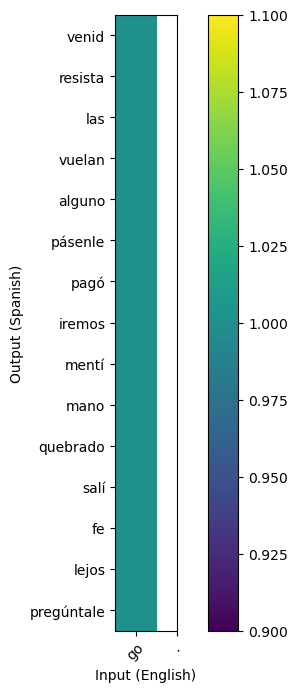

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Your plotting logic
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(attention.cpu().numpy(), cmap='viridis')
    
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(translation)))
    ax.set_xticklabels(sentence, rotation=45)
    ax.set_yticklabels(translation)
    
    plt.xlabel("Input (English)")
    plt.ylabel("Output (Spanish)")
    plt.colorbar(im)
    
    plt.show() 

import torch

def final_visualize(sentence, model, en_vocab, sp_vocab, device):
    model.eval()
    tokens = sentence.lower().split()
    src_idx = torch.LongTensor([en_vocab.get(w, 3) for w in tokens]).unsqueeze(0).to(device)
    
    with torch.no_grad():
        res = model.encoder(src_idx)
        
        # --- ROBUST STATE EXTRACTION ---
        if isinstance(res, tuple):
            encoder_outputs = res[0]
            # Try to get hidden/cell from the tuple
            try:
                if isinstance(res[1], tuple): # Standard LSTM: (out, (h, c))
                    hidden, cell = res[1]
                else: # Flat tuple: (out, h, c)
                    hidden, cell = res[1], res[2]
            except (IndexError, TypeError):
                # If only outputs were returned in a tuple
                hidden = torch.zeros(1, 1, model.decoder.rnn.hidden_size).to(device)
                cell = torch.zeros(1, 1, model.decoder.rnn.hidden_size).to(device)
        else:
            # If only a single Tensor was returned (Transformer/Linear)
            encoder_outputs = res
            hidden = torch.zeros(1, 1, model.decoder.rnn.hidden_size).to(device)
            cell = torch.zeros(1, 1, model.decoder.rnn.hidden_size).to(device)
            
        translated_tokens = []
        attentions = []
        # Start with the <sos> token
        input_step = torch.LongTensor([sp_vocab['<sos>']]).to(device)
        
        for _ in range(15):
            # Pass to decoder
            output, hidden, cell, attn = model.decoder(input_step, hidden, cell, encoder_outputs)
            
            top1 = output.argmax(1)
            word = inv_sp_vocab[top1.item()]
            
            if word == '<eos>': break
            
            translated_tokens.append(word)
            attentions.append(attn.squeeze(0)) # [src_len]
            input_step = top1
            
    if attentions:
        # Stack all attention vectors into a 2D matrix
        attn_matrix = torch.stack(attentions)
        
        # Trigger the plot
        print(f"English: {sentence}")
        print(f"Spanish: {' '.join(translated_tokens)}")
        plot_attention(tokens, translated_tokens, attn_matrix)
    else:
        print("No translation generated. Your model might need more training.")

# --- RUN THIS ---
final_visualize(df['eng'].iloc[0], model, en_vocab, sp_vocab, device)